In [1]:
import cv2
import numpy as np
import scipy.sparse.linalg

import utils

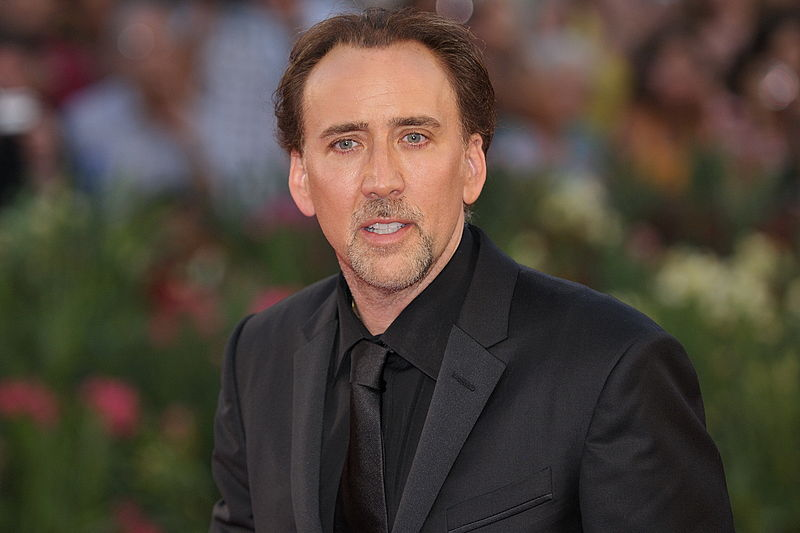

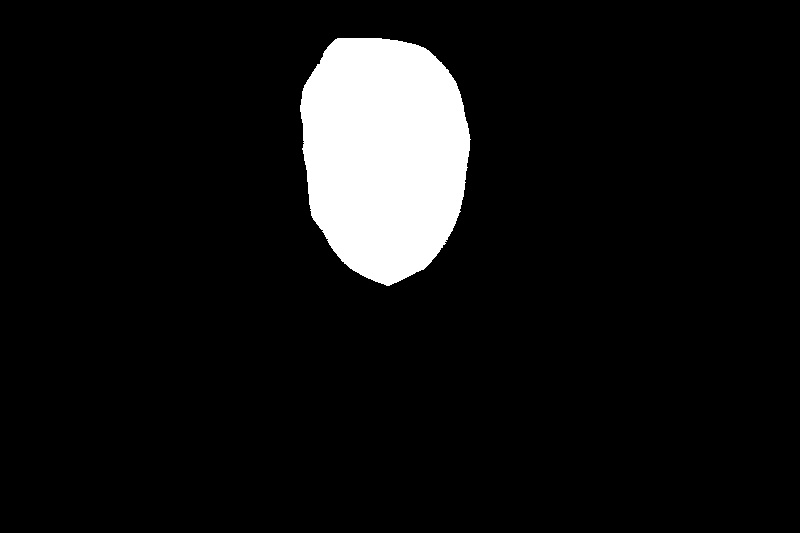

In [2]:
folder_path = "img/archive (1)/"

source = utils.open_and_print_image(folder_path + "source_flat")

mask = utils.open_and_print_image(folder_path + "mask_flat", is_mask=True)


In [3]:
height, width, mask, inner_mask, boundary_mask, pixel_ids, inner_ids, boundary_ids, mask_ids, inner_pos, boundary_pos, mask_pos = utils.setup_variables(mask)
channels = 3

# create a map of the most prominent edges in the image (=most prominent feature)
edge = cv2.Canny((utils.rgb2gray(source) * 255).astype(np.uint8), 100, 200)
edge = utils.dilate_img(edge, 3)
edge = np.where(edge > 0, 1, 0)

In [4]:
A = utils.create_matrix_A(mask_ids, inner_ids, boundary_ids, inner_pos, boundary_pos, width)

In [5]:
def compute_gradients(src):
    # compute gradient and mantain only the most significant features (according to the edge map)
    I_x, I_y = utils.compute_gradient(src)
    # mask the gradients with the edge map and compute the second order derivatives
    I_xx, _ = utils.compute_gradient(edge * I_x, forward=False)
    _, I_yy = utils.compute_gradient(edge * I_y, forward=False)
    return I_xx + I_yy

In [6]:
def poisson_texture_flatten_channel(src):
    gradients = compute_gradients(src)

    boundary_pixel_values = utils.get_masked_values(src, boundary_mask).flatten()
    inner_gradient_values = utils.get_masked_values(gradients, inner_mask).flatten()

    # Construct b
    b = utils.construct_b(mask_ids, inner_pos, boundary_pos, inner_gradient_values, boundary_pixel_values)

    # Solve Ax = b
    x = scipy.sparse.linalg.spsolve(A, b)
    
    # reconstruct the new image (single channel)
    new_src = np.zeros_like(src)
    new_src.flat[mask_pos] = x
    img = utils.get_alpha_blended_img(new_src, src, mask)
    img = np.clip(img, 0, 1)

    return img

In [7]:
def poisson_texture_flatten():
    return np.dstack([poisson_texture_flatten_channel(source[..., i]) for i in range(source.shape[-1])])

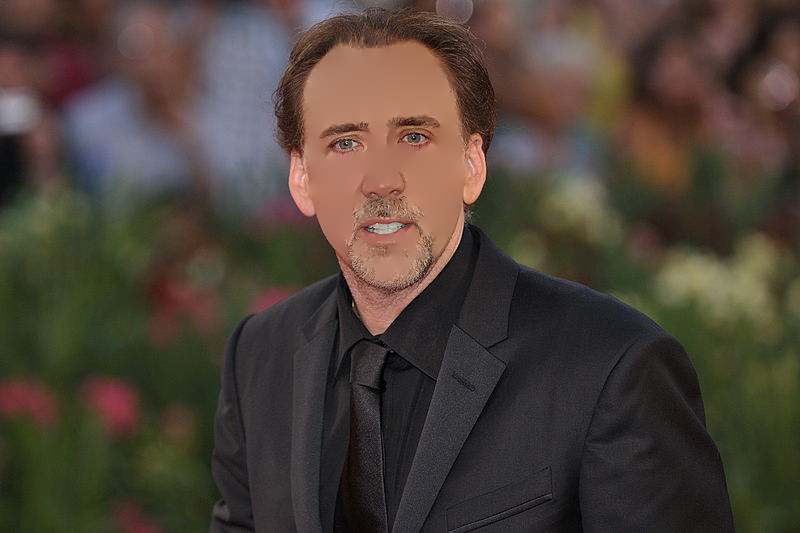

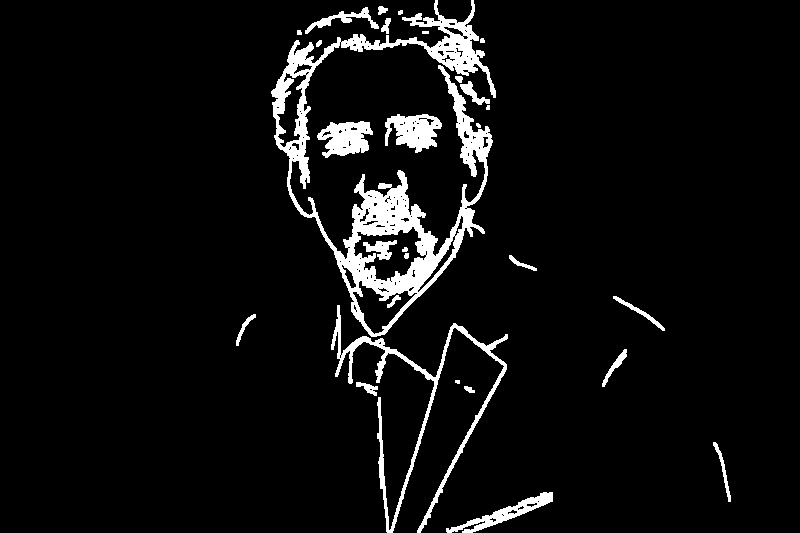

In [8]:
img = poisson_texture_flatten()

utils.save_and_print(img, folder_path, "result.png")

utils.save_and_print(edge, folder_path, "edge_canny.png")